In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM,BatchNormalization, Bidirectional
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
DataPath=  '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/RML2016.10b.dat' #'/content/drive/MyDrive/ModulationClassification/RML2016.10b.dat'

In [ ]:
pickle_in = open(DataPath,"rb")
data = pickle.load(pickle_in, encoding="bytes")

In [ ]:
def load_data(data):
  s = np.empty((0,128,2))
  l=np.array([])
  for key in data.keys():
    # load samples
    x,y=key
    x = x.decode('ascii')
    samples = np.array(data.get(key)).transpose(0, 2, 1)
    # create labels
    labels = np.repeat(x+'_'+str(y),samples.shape[0])
    l=np.concatenate([l,labels])
    s=np.vstack((s,samples))
    print('key',key)
    print("samples:",samples.shape)
    print('labels',labels.shape)
  return l,s,data.keys()
  

In [ ]:
def first_drev(data):
  drev = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = np.gradient(data[i*6000:i*6000+6000][:][:],axis=1)
    drev=np.vstack((drev,tmp))
    del tmp
  return drev


In [ ]:
def integral(data):
  data=np.pad(data, [(0, 0),(0,0),(0,1)], 'constant')
  integral = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = scipy.integrate.cumtrapz(data[i*6000:i*6000+6000][:][:],dx=1)
    integral=np.vstack((integral,tmp))
    del tmp
  return integral

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def create_model():
  number_of_channels = 2 
  model = Sequential()
  
  model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(128,2))))
  model.add(Bidirectional(LSTM(64)))

  model.add(BatchNormalization())

  model.add(Dense(10, activation ='softmax'))

  
  return model

In [ ]:
# get samples and labels
labels, samples,classes = load_data(data)

key (b'QPSK', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'AM-DSB', -4)
samples: (6000, 128, 2)
labels (6000,)
key (b'GFSK', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 18)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', -20)
samples: (6000, 128, 2)
labels (6000,)
key (b'8PSK', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'CPFSK', 10)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 4)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', -2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QPSK', -20)
samples: (

In [ ]:
# test drevative
d = np.array(first_drev(samples))
print("drevative:",d.shape)



In [ ]:
# test integration
i = np.array(integral(samples))
print("integral:",i.shape)

In [ ]:
import gc
# to encode the labels
lb = LabelEncoder()
print(samples.shape)
print(labels.shape)
print(labels)
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)

# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)
del samples
del labels
del data
gc.collect()
# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
del y_train
del y_val
gc.collect()

(1200000, 128, 2)
(1200000,)
['QPSK_2' 'QPSK_2' 'QPSK_2' ... 'WBFM_12' 'WBFM_12' 'WBFM_12']


0

Epoch 1/30
24938/24938 [==============================] - 535s 21ms/step - loss: 1.8252 - accuracy: 0.2828 - val_loss: 1.4593 - val_accuracy: 0.4100
Epoch 2/30
24938/24938 [==============================] - 519s 21ms/step - loss: 1.6674 - accuracy: 0.3355 - val_loss: 1.2003 - val_accuracy: 0.4838
Epoch 3/30
24938/24938 [==============================] - 517s 21ms/step - loss: 1.2811 - accuracy: 0.4597 - val_loss: 1.1261 - val_accuracy: 0.5100
Epoch 4/30
24938/24938 [==============================] - 512s 21ms/step - loss: 1.0910 - accuracy: 0.5386 - val_loss: 1.0433 - val_accuracy: 0.5611
Epoch 5/30
24938/24938 [==============================] - 512s 21ms/step - loss: 1.0293 - accuracy: 0.5704 - val_loss: 1.0200 - val_accuracy: 0.5809
Epoch 6/30
24938/24938 [==============================] - 514s 21ms/step - loss: 0.9914 - accuracy: 0.5975 - val_loss: 0.9553 - val_accuracy: 0.6118
Epoch 7/30
24938/24938 [==============================] - 513s 21ms/step - loss: 0.9615 - accuracy: 0.6141

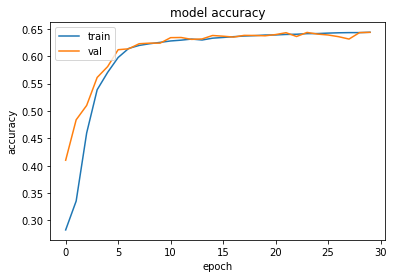

In [ ]:
# training
model = create_model()
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 30,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb))
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

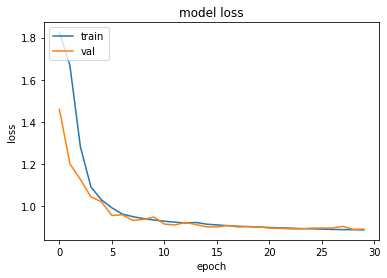

In [ ]:
# Plot model loss over ephocs
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/backup/lstm_raw.h5')

In [ ]:
del x_train
del y_train_lb
gc.collect()

7159

In [ ]:
# evaluate test set
# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.6430888772010803


In [ ]:
# to get confusion matrix
y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)


In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',19178,1827,277,944,3282,703,111,960,7941,777
b'AM-DSB',0,28563,98,196,2145,276,10,25,2808,1879
b'BPSK',19,1816,22116,413,3063,1755,47,191,5841,739
b'CPFSK',32,1770,189,23119,3552,557,45,294,5624,818
b'GFSK',1,2068,161,602,27413,393,24,78,4065,1195
b'PAM4',0,1354,1018,303,2256,26167,50,224,4120,508
b'QAM16',415,1006,180,731,1962,615,21305,3871,5437,478
b'QAM64',349,668,176,652,1108,511,2023,26129,4091,293
b'QPSK',424,1773,292,865,3241,625,70,767,27203,740
b'WBFM',0,19307,97,272,2775,269,15,26,2920,10319


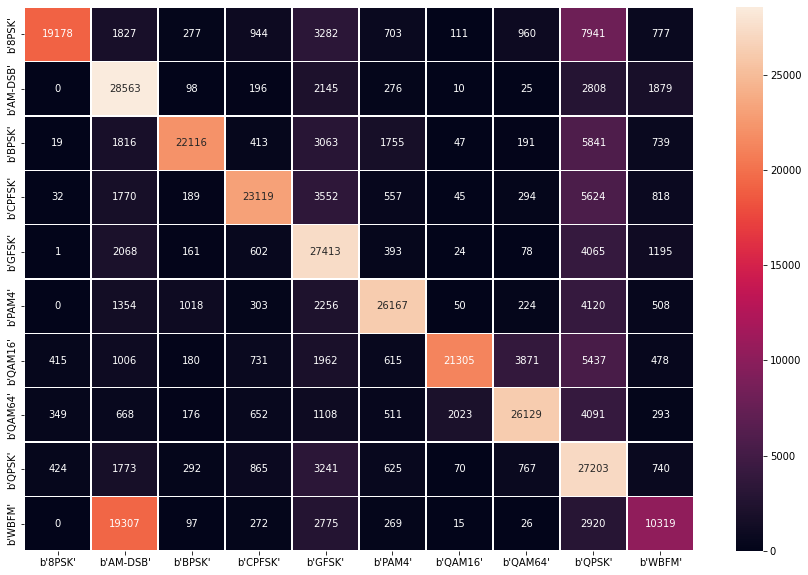

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.7167638695284315
Recall:  0.6430888888888888
F-score:  0.6500858349086865


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.82,11.02,13.26,16.73,22.94,30.93,38.39,55.54,72.53,85.16,90.85,92.5,92.91,93.34,93.03,93.24,93.1,93.24,93.19,93.43


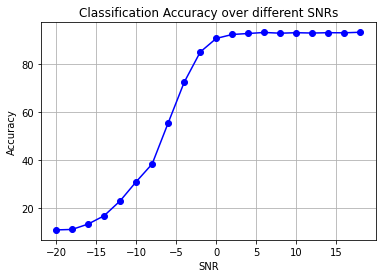

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)